In [1]:
%cd '/home/urbanaq/cams_downscaling'

/home/urbanaq/cams_downscaling


In [2]:
from cams_downscaling.utils import read_config

config = read_config('/home/urbanaq/cams_downscaling/config')

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
from pathlib import Path

In [4]:
variable = 'NO2'
region = 'poland'

bbox = config['regions'][region]['bbox']

bbox

{'min_lat': 48.8, 'min_lon': 13.9, 'max_lat': 54.9, 'max_lon': 24.3}

# 0. Preprocesament

1. Temporal resampling datasets 
2. Regriding datasets (Bilinear interpolation)
3. Define Regions of Interest (ROIs) 
4. Generate station permutations for each ROI(X-1/1) 
5. Interpolate stations (X-1) (Nearest neighbours + Kriging) 
6. Add geographical proximity covariates 
7. Add interpolation covariates 

# 1. CAMS data

In [5]:
from cams_downscaling.readers.cams import load_cams

cams_path = config['paths']['cams']
cams_path = Path(cams_path, variable.lower(), region)

#dates = pd.date_range('2022-01-01T00:00:00', '2023-12-31T23:00:00', freq='h')
dates = pd.date_range('2022-01-01T00:00:00', '2022-01-01T23:00:00', freq='h')
cams = load_cams(cams_path, dates=dates)

cams

TimeseriesGridData(
    > Axes:
        - date: 24 elements
        - lat: 61 elements
        - lon: 104 elements
    > Data:
        - no2: (24, 61, 104)
    > Memory: 0.58 MB
)

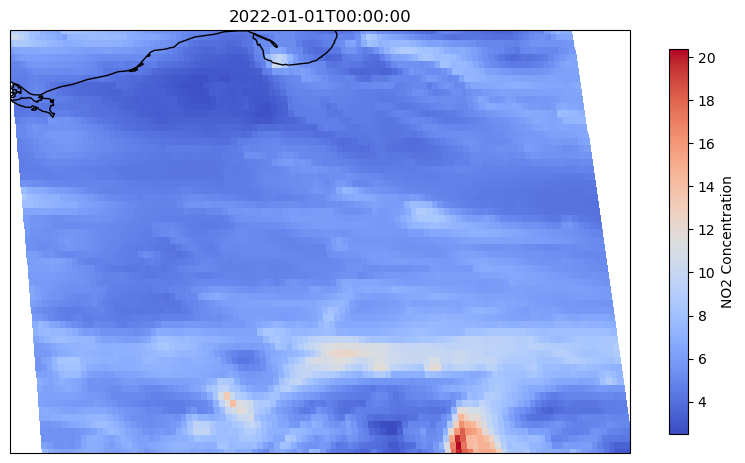

In [6]:
data = cams[pd.to_datetime('2022-01-01T00:00:00'), :, :].values['no2']

# Define the extent
extent = (cams.lon.min(), cams.lon.max(), cams.lat.min(), cams.lat.max())

# Create a meshgrid for the coordinates
lon, lat = np.meshgrid(cams.lon, cams.lat)

# Plotting
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")

# Using pcolormesh for accurate pixel plotting
im = ax.pcolormesh(lon, lat, data.squeeze(), cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree())

# Set the extent of the map
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
cbar.set_label('NO2 Concentration')

# Set the title
plt.title('2022-01-01T00:00:00')

# Show the plot
plt.show()

## 1.1. Temporal resampling

CAMS is already in hourly format, so no need to resample

## 1.2. Regridding datasets

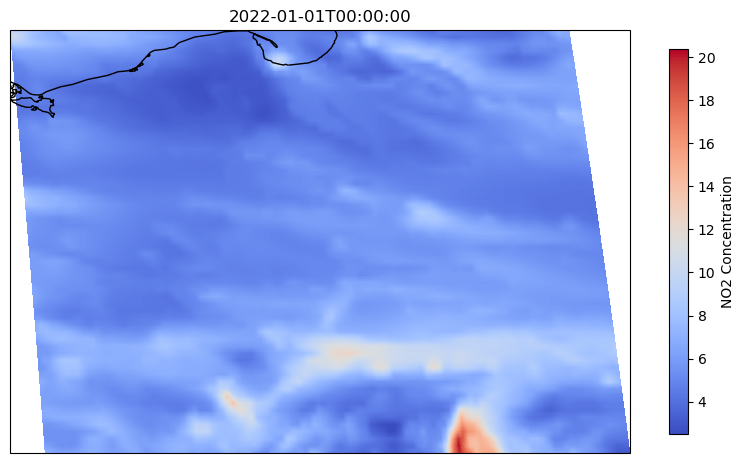

In [7]:
new_resolution = 0.01

new_lat = np.arange(cams.lat.min(), cams.lat.max(), new_resolution)
new_lon = np.arange(cams.lon.min(), cams.lon.max(), new_resolution)

new_cams = cams.interpolate(lat=new_lat, lon=new_lon)
new_data = new_cams[pd.to_datetime('2022-01-01T00:00:00'), :, :].values['no2']

# Plotting
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")

# Using pcolormesh for accurate pixel plotting
im = ax.pcolormesh(new_lon, new_lat, new_data.squeeze(), cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree())

# Set the extent of the map
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
cbar.set_label('NO2 Concentration')

# Set the title
plt.title('2022-01-01T00:00:00')

# Show the plot
plt.show()

In [8]:
new_cams

TimeseriesGridData(
    > Axes:
        - date: 24 elements
        - lat: 600 elements
        - lon: 1031 elements
    > Data:
        - no2: (24, 600, 1031)
    > Memory: 113.27 MB
)

In [9]:
# Finished, delete the cams to free up memory
del cams
del new_cams

# 2. EEA Stations

In [63]:
import pandas as pd

stations = pd.read_csv(
    config['paths']['stations'] + '/stations.csv',
    usecols=["Air Quality Station EoI Code", "Longitude", "Latitude", "Country"],
    index_col="Air Quality Station EoI Code")

stations = stations[
    (stations["Longitude"].between(bbox["min_lon"], bbox["max_lon"])) & 
    (stations["Latitude"].between(bbox["min_lat"], bbox["max_lat"]))]

stations.index.name = 'station'

stations = stations[~stations.index.duplicated(keep='first')]

stations = stations[stations["Country"].isin(['Poland'])].drop(columns=["Country"])

stations

,Longitude,Latitude
station,,
PL0003R,15.7397,50.7364
PL0028A,15.3122,50.9125
PL0054A,14.9413,50.9722
PL0057A,16.0751,51.5024
PL0059A,16.4867,50.8424
...,...,...
PL0774A,16.0893,53.7557
PL0802A,15.5799,54.1826
PL0815A,14.7761,53.9697


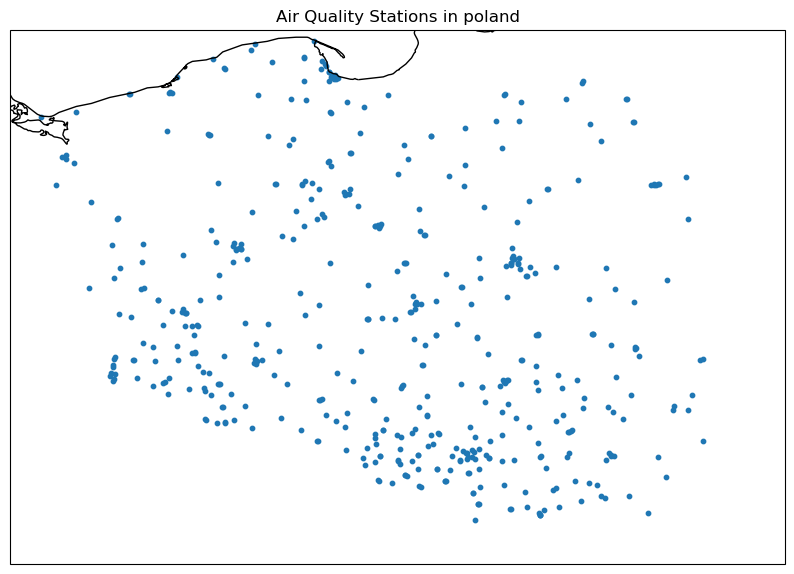

In [64]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")
ax.set_extent([bbox["min_lon"], bbox["max_lon"], bbox["min_lat"], bbox["max_lat"]])
ax.scatter(stations.Longitude, stations.Latitude, transform=ccrs.PlateCarree(), s=10)
plt.title(f"Air Quality Stations in {region}")
plt.show()

In [101]:
observations = pd.read_csv(config['paths']['stations'] + '2022/PL.csv', usecols=['time', 'station', variable], index_col=['time', 'station'], parse_dates=['time'])

# Create a dataframe with all combinations of timestamps and stations
all_combinations = pd.MultiIndex.from_product([
    observations.index.get_level_values('time').unique(),
    observations.index.get_level_values('station').unique()],
    names=['time', 'station']).to_frame(index=False)

observations = pd.merge(all_combinations, observations, on=['time', 'station'], how='left').set_index(['time', 'station'])

# Join the station coordinates
observations = observations.join(stations, how='left', on='station')

observations


,time,station
0,2022-01-01,PL0002R
1,2022-01-01,PL0003R
2,2022-01-01,PL0004R
3,2022-01-01,PL0005R
4,2022-01-01,PL0008A
...,...,...
2102635,2023-01-01,PL0739A
2102636,2023-01-01,PL0742A
2102637,2023-01-01,PL0744A
2102638,2023-01-01,PL0745A


In [24]:
# Drop observations where NO2 is NaN
observations = observations.groupby('station').filter(lambda x: x['NO2'].notnull().any())

# Drop observations where Latitude is NaN
observations = observations.groupby('station').filter(lambda x: x['Latitude'].notnull().any())

# Drop stations where NO2 is NaN
stations = stations[stations.index.isin(observations.index.get_level_values('station').unique())]

observations

NO2  Longitude  Latitude
time       station                              
2022-01-01 PL0002R   3.0000    21.9724   51.8144
           PL0004R   4.6000    17.5345   54.7541
           PL0005R   5.4095    22.0381   54.1248
           PL0008A  17.0391    18.9750   50.2646
           PL0014A   4.4000    20.7919   51.8352
...                     ...        ...       ...
2023-01-01 PL0705A      NaN    19.0486   49.8021
           PL0721A      NaN    22.4703   53.6398
           PL0736A      NaN    22.0047   50.0407
           PL0739A      NaN    20.9061   52.2077
           PL0742A      NaN    18.9756   49.9378

[1051320 rows x 3 columns]

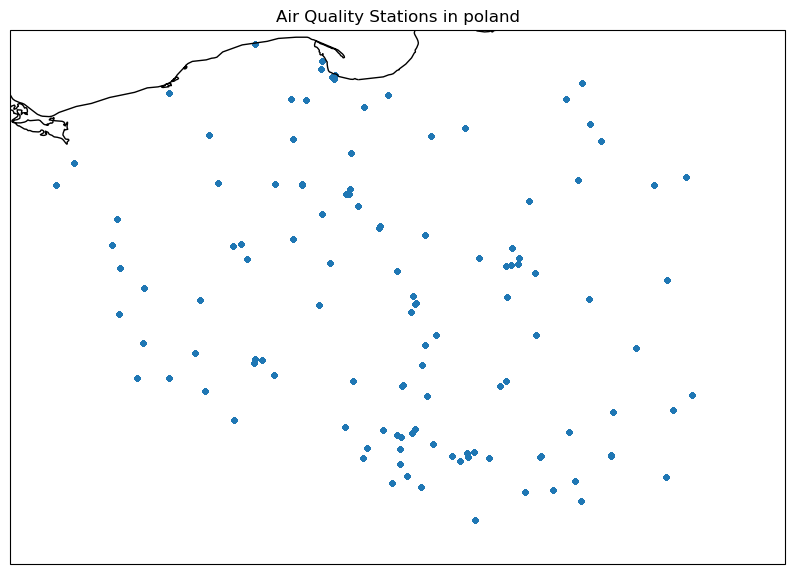

In [25]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")
ax.set_extent([bbox["min_lon"], bbox["max_lon"], bbox["min_lat"], bbox["max_lat"]])
ax.scatter(observations.Longitude, observations.Latitude, transform=ccrs.PlateCarree(), s=10)
plt.title(f"Air Quality Stations in {region}")
plt.show()

## 2.3. Define ROIs

In [26]:
from sklearn.cluster import DBSCAN

# Define the clustering model
dbscan = DBSCAN(eps=0.3, min_samples=5)

# Fit the model
clusters = dbscan.fit_predict(stations[['Longitude', 'Latitude']])
stations.loc[:, 'cluster'] = clusters
stations = stations[stations.cluster != -1]

stations

/tmp/ipykernel_12854/1787713155.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations.loc[:, 'cluster'] = clusters


,Longitude,Latitude,cluster
station,,,
PL0039A,20.0535,50.0693,0
PL0273A,19.8304,49.9710,0
PL0501A,19.9492,50.0106,0
PL0552A,19.4775,50.1594,0
PL0618A,20.2592,50.0075,0
PL0640A,19.7268,50.0250,0
PL0641A,19.9460,50.0574,0
PL0129A,20.9559,52.4076,1
PL0134A,20.8375,52.1917,1


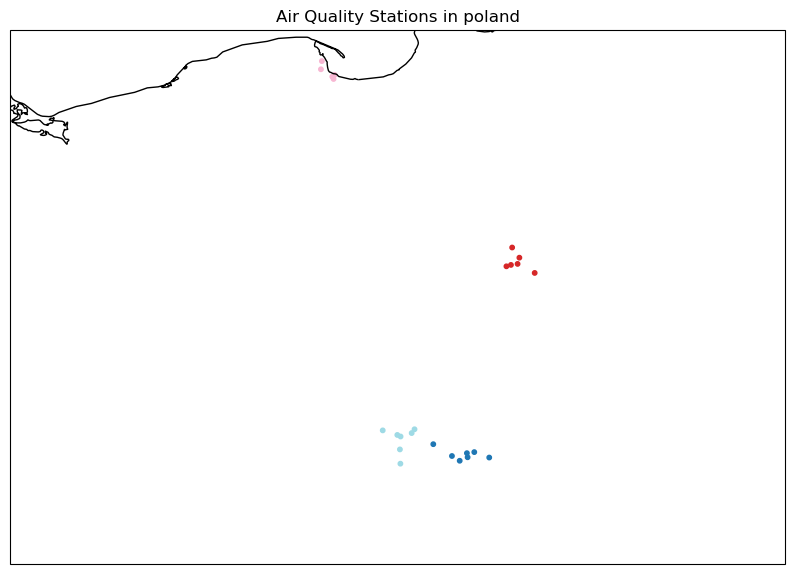

In [27]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")
ax.set_extent([bbox["min_lon"], bbox["max_lon"], bbox["min_lat"], bbox["max_lat"]])
scatter = ax.scatter(stations.Longitude, stations.Latitude, transform=ccrs.PlateCarree(), s=10, c=stations.cluster, cmap='tab20')
plt.title(f"Air Quality Stations in {region}")
plt.show()

In [28]:
region_box = stations.groupby('cluster').agg({'Latitude': ['min', 'max'], 'Longitude': ['min', 'max']})

region_box['n'] = stations.cluster.value_counts()
region_box['area (km²)'] = 111*(region_box['Latitude']['max'] - region_box['Latitude']['min']) * 111*(region_box['Longitude']['max'] - region_box['Longitude']['min'])
region_box['area (hm²)'] = region_box['area (km²)'] * 100
region_box['density (km²)'] = region_box['n'] / region_box['area (km²)']
region_box['density (hm²)'] = region_box['n'] / region_box['area (hm²)']

region_box

Latitude          Longitude           n   area (km²)     area (hm²)  \
             min      max       min      max                                  
cluster                                                                       
0        49.9710  50.1594   19.4775  20.2592  7  1814.541762  181454.176188   
1        52.1157  52.4076   20.8375  21.2373  6  1437.880660  143788.066002   
2        54.3533  54.5608   18.4649  18.6575  5   492.402605   49240.260450   
3        49.9378  50.3291   18.7724  19.2312  7  2211.969909  221196.990924   

        density (km²) density (hm²)  
                                     
cluster                              
0            0.003858      0.000039  
1            0.004173      0.000042  
2            0.010154      0.000102  
3            0.003165      0.000032

In [29]:
observations = observations.join(stations['cluster'], on='station', how='inner')

observations

NO2  Longitude  Latitude  cluster
time       station                                        
2022-01-01 PL0008A  17.03910    18.9750   50.2646        3
           PL0039A   6.23046    20.0535   50.0693        0
           PL0045A   8.55242    18.6353   54.3533        2
           PL0047A   6.56573    18.6575   54.4008        2
           PL0048A   4.55507    18.4933   54.5608        2
...                      ...        ...       ...      ...
2023-01-01 PL0618A       NaN    20.2592   50.0075        0
           PL0640A       NaN    19.7268   50.0250        0
           PL0641A       NaN    19.9460   50.0574        0
           PL0739A       NaN    20.9061   52.2077        1
           PL0742A       NaN    18.9756   49.9378        3

[219025 rows x 4 columns]

## 2.1. Temporal Resampling

In [30]:
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

def fill_missing_values(observations, variable):
    df = observations.copy()
    df['hour'] = df.index.get_level_values('time').hour
    df['dayofweek'] = df.index.get_level_values('time').dayofweek
    df['weekofyear'] = df.index.get_level_values('time').isocalendar().week.values
    df[f'last_observed_{variable}'] = df.groupby('station')[variable].shift(1).transform(lambda x: x.ffill())
    
    missing = df[df[variable].isnull()]
    df = df.dropna(subset=[variable])
    
    features = ['hour', 'dayofweek', 'weekofyear', 'Longitude', 'Latitude', f'last_observed_{variable}']
    target = variable
    
    X = df[features]
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = make_pipeline(StandardScaler(), HistGradientBoostingRegressor())
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    print(f'R² Score: {r2_score(y_test, y_pred)}')
    
    missing = missing.join(
        df.groupby(['station', 'hour', 'dayofweek'])[f'last_observed_{variable}'].mean(),
        on=['station', 'hour', 'dayofweek'],
        rsuffix='_mean')
    
    missing[f'last_observed_{variable}'] = missing[f'last_observed_{variable}'].fillna(missing[f'last_observed_{variable}_mean'])
    
    missing = missing.drop(columns=[f'last_observed_{variable}_mean'])
    
    # Predict the missing values
    missing[variable] = model.predict(missing[features])
    observations = pd.concat([df, missing])[[variable, 'Latitude', 'Longitude', 'cluster']]
    observations = observations.sort_index()
    
    return observations

observations = fill_missing_values(observations, variable=variable)

observations

R² Score: 0.8707943351586814


NO2  Latitude  Longitude  cluster
time       station                                         
2022-01-01 PL0008A  17.039100   50.2646    18.9750        3
           PL0039A   6.230460   50.0693    20.0535        0
           PL0045A   8.552420   54.3533    18.6353        2
           PL0047A   6.565730   54.4008    18.6575        2
           PL0048A   4.555070   54.5608    18.4933        2
...                       ...       ...        ...      ...
2023-01-01 PL0618A   5.137051   50.0075    20.2592        0
           PL0640A   5.901193   50.0250    19.7268        0
           PL0641A  12.759501   50.0574    19.9460        0
           PL0739A   3.493595   52.2077    20.9061        1
           PL0742A   9.600731   49.9378    18.9756        3

[219025 rows x 4 columns]

## 2.4. Generate permutations for each cluster

In [31]:
n=5

permutations = pd.get_dummies(
    observations.groupby(['time', 'cluster'], group_keys=False)
    .apply(lambda x: x.sample(n).assign(i=range(n)), include_groups=False)
    .get('i').astype(str).reindex(observations.index)
).add_prefix('perm_')

permutations

perm_0  perm_1  perm_2  perm_3  perm_4
time       station                                        
2022-01-01 PL0008A   False   False   False   False    True
           PL0039A   False   False   False   False   False
           PL0045A    True   False   False   False   False
           PL0047A   False   False   False   False    True
           PL0048A   False   False   False    True   False
...                    ...     ...     ...     ...     ...
2023-01-01 PL0618A   False   False    True   False   False
           PL0640A   False   False   False    True   False
           PL0641A   False    True   False   False   False
           PL0739A   False    True   False   False   False
           PL0742A   False   False   False   False    True

[219025 rows x 5 columns]

In [32]:
from scipy.spatial import KDTree

def interpolate_points(x, variable):
    perm = x.filter(like='perm_').reset_index(drop=True)
    x = x[['Latitude', 'Longitude', variable]].reset_index(drop=True)

    # Separate points and observations
    mask = perm.values.T
    all_points = x.values
    
    interpolated_results = []

    for mask_row in mask:
        points = all_points[~mask_row]
        obs = all_points[mask_row]

        tree = KDTree(points[:, :2])
        dist, idx = tree.query(obs[:, :2])
        
        interpolated_results.append(np.hstack([
            obs,
            points[idx][:, 2:3],
            dist[:, np.newaxis]]))
    
    # Combine all results into a single DataFrame
    return pd.DataFrame(
        np.vstack(interpolated_results),
        columns=['Latitude', 'Longitude', f'{variable}_obs', f'{variable}_interp', 'dist'])
    
# Apply the function to the dataset
dataset = observations.join(permutations).groupby(['time', 'cluster']).apply(interpolate_points, variable=variable)
dataset = dataset.reset_index().drop(columns=['level_2'])

dataset

/tmp/ipykernel_12854/20304055.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataset = observations.join(permutations).groupby(['time', 'cluster']).apply(interpolate_points, variable=variable)


,time,cluster,Latitude,Longitude,NO2_obs,NO2_interp,dist
0,2022-01-01,0,50.0106,19.9492,6.454740,11.439600,0.046909
1,2022-01-01,0,50.0250,19.7268,4.095390,4.839800,0.116829
2,2022-01-01,0,50.0075,20.2592,7.726600,6.230460,0.214783
3,2022-01-01,0,50.0574,19.9460,11.439600,6.454740,0.046909
4,2022-01-01,0,50.1594,19.4775,13.637300,4.095390,0.283220
...,...,...,...,...,...,...,...
175215,2023-01-01,3,50.3165,18.7724,2.909020,8.950637,0.209142
175216,2023-01-01,3,50.0999,18.9902,9.380670,9.386224,0.149794
175217,2023-01-01,3,50.3291,19.2312,6.228182,7.146325,0.063623
175218,2023-01-01,3,50.2860,19.1844,7.146325,6.228182,0.063623


# 3. Elevation

In [33]:
from cams_downscaling.readers.topography import load_topography

new_lat = np.arange(bbox["min_lat"], bbox["max_lat"], new_resolution)
new_lon = np.arange(bbox["min_lon"], bbox["max_lon"], new_resolution)

topography = load_topography("/data1/data_prep/nasa_topo/topo.tiff", bbox)
topography = topography.interpolate(lat=new_lat, lon=new_lon)

topography

GridData(
    > Axes:
        - lat: 611 elements
        - lon: 1040 elements
    > Data:
        - elevation: (611, 1040)
    > Memory: 4.85 MB
)

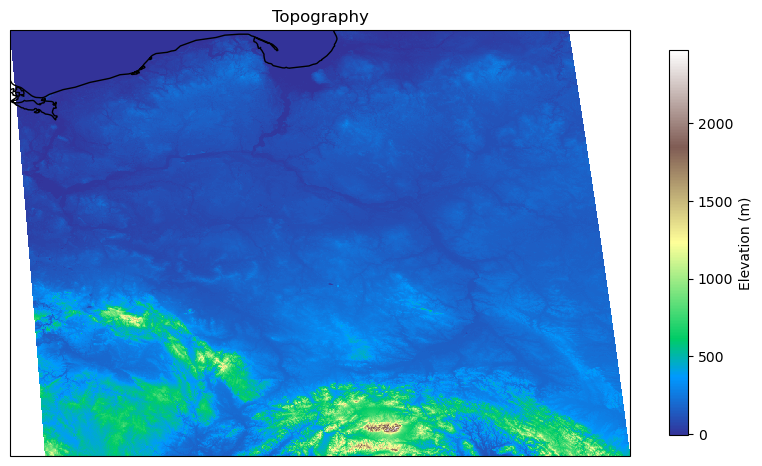

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

data = topography.values['elevation']

# Define the extent
extent = (topography.lon.min(), topography.lon.max(), topography.lat.min(), topography.lat.max())

# Create a meshgrid for the coordinates
lon, lat = np.meshgrid(topography.lon, topography.lat)

# Plotting
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")

# Set the extent of the map
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Plot the data
im = ax.pcolormesh(lon, lat, data.squeeze(), cmap=plt.cm.terrain, transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
cbar.set_label('Elevation (m)')

# Set the title
plt.title('Topography')

# Show the plot
plt.show()


In [35]:
topography = pd.concat([
    load_topography(
        "/data1/data_prep/nasa_topo/topo.tiff",
        {k: v for k, v in zip(['min_lat', 'max_lat', 'min_lon', 'max_lon'], region_box.loc[c][['Latitude', 'Longitude']].values)})
    .interpolate(
        lat=stations[stations.cluster == c]['Latitude'],
        lon=stations[stations.cluster == c]['Longitude'],
        grid=False).to_frame().set_index(stations[stations.cluster == c].index)
    for c in stations.cluster.unique()])

topography

,elevation
station,
PL0039A,201.7140
PL0273A,227.9800
PL0501A,223.7324
PL0552A,341.0000
PL0618A,214.9000
PL0640A,260.5348
PL0641A,208.2300
PL0129A,89.4800
PL0134A,98.8400


## 3.X. Add external covariates

In [36]:
from cams_downscaling.readers.cams import load_cams

cams_path = config['paths']['cams']
cams_path = Path(cams_path, variable.lower(), region)

dates = observations.index.get_level_values('time').unique()

cams = load_cams(cams_path, dates=dates)

cams =  cams.interpolate(
    lat=stations.sort_index()['Latitude'],
    lon=stations.sort_index()['Longitude'],
    grid=False).to_frame()

cams.index = observations.sort_index().index
cams.columns = [v.upper() for v in cams.columns]

cams

NO2
time       station           
2022-01-01 PL0008A  10.076461
           PL0039A  11.652202
           PL0045A   6.246401
           PL0047A   7.205726
           PL0048A   5.019316
...                       ...
2023-01-01 PL0618A   4.646251
           PL0640A   4.262701
           PL0641A   5.421475
           PL0739A   7.672653
           PL0742A   6.237910

[219025 rows x 1 columns]

In [37]:
from cams_downscaling.readers.era5 import load_era5

dates = observations.index.get_level_values('time').unique()

era5 = load_era5(Path(config['paths']['era5']), region, dates)

era5 = era5.interpolate(
    lat=stations.sort_index()['Latitude'],
    lon=stations.sort_index()['Longitude'],
    grid=False).to_frame()

era5.index = observations.sort_index().index

era5

blh      iews      inss
time       station                                
2022-01-01 PL0008A  692.258062  0.412014  0.017955
           PL0039A  779.995168  0.676206  0.038894
           PL0045A  378.132195  0.254178 -0.031548
           PL0047A  382.138771  0.237360 -0.029210
           PL0048A  403.685184  0.208140 -0.014604
...                        ...       ...       ...
2023-01-01 PL0618A  386.476616  0.309272  0.286170
           PL0640A  407.479183  0.331161  0.324281
           PL0641A  436.654513  0.374297  0.318682
           PL0739A  662.778257  0.475456  0.358536
           PL0742A  356.729281  0.297400  0.473144

[219025 rows x 3 columns]

In [38]:
"""import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
from scipy.spatial import KDTree
from joblib import Parallel, delayed

def kriging_interpolation(points, obs, kriging=True):
    lats = points[:, 0]
    lons = points[:, 1]
    Z = points[:, -1]

    # KDTree interpolation
    tree = KDTree(points[:, :2])
    dist, idx = tree.query(obs[:, :2])

    if kriging:
        # If all points are the same, return the same value for all observations
        if len(set(Z)) == 1:
            return np.hstack([
                obs,
                points[idx][:, -1:],
                points[idx][:, -1:],
                dist[:, np.newaxis],
                np.zeros((len(obs), 1))])

        # Define the Kriging model
        OK = OrdinaryKriging(
            lats, lons, Z,
            coordinates_type='geographic',
            verbose=False,
            enable_plotting=False)

        # Perform the interpolation
        interp_values, ss = OK.execute('points', obs[:, 0], obs[:, 1])

        return np.hstack([
            obs,
            points[idx][:, -1:],
            interp_values[:, np.newaxis],
            dist[:, np.newaxis],
            ss[:, np.newaxis]])
    
    return np.hstack([
        obs,
        points[idx][:, -1:],
        dist[:, np.newaxis]])

def interpolate_points(x, variable, kriging=True):
    perm = x.filter(like='perm_').reset_index(drop=True)
    x = x[[
        'Latitude', 'Longitude',
        'elevation', f'{variable}_cams',
        variable]].reset_index(drop=True)

    # Separate points and observations
    mask = perm.values.T
    all_points = x.values
    
    # Parallelize the interpolation process
    interpolated = Parallel(n_jobs=-1)(delayed(kriging_interpolation)(
        all_points[~mask_row], all_points[mask_row], kriging) for mask_row in mask)
    
    # Combine all results into a single DataFrame
    if kriging:
        return pd.DataFrame(
            np.vstack(interpolated),
            columns=[
                'Latitude', 'Longitude',
                'elevation', f'{variable}_cams',
                f'{variable}_obs', f'{variable}_kdtree', f'{variable}_kriging', 'dist', 'ss'])

    return pd.DataFrame(
        np.vstack(interpolated),
        columns=[
            'Latitude', 'Longitude',
            'elevation', f'{variable}_cams',
            f'{variable}_obs', f'{variable}_kdtree', 'dist'])

# Apply the function to the dataset
dataset = observations.join(topography)
dataset[f'{variable}_cams'] = cams[variable]

dataset = dataset.join(permutations).groupby(['time', 'cluster']).apply(
    interpolate_points,
    variable=variable.upper(),
    kriging=True).reset_index().drop(columns=['level_2'])

dataset"""

"import numpy as np\nimport pandas as pd\nfrom pykrige.ok import OrdinaryKriging\nfrom scipy.spatial import KDTree\nfrom joblib import Parallel, delayed\n\ndef kriging_interpolation(points, obs, kriging=True):\n    lats = points[:, 0]\n    lons = points[:, 1]\n    Z = points[:, -1]\n\n    # KDTree interpolation\n    tree = KDTree(points[:, :2])\n    dist, idx = tree.query(obs[:, :2])\n\n    if kriging:\n        # If all points are the same, return the same value for all observations\n        if len(set(Z)) == 1:\n            return np.hstack([\n                obs,\n                points[idx][:, -1:],\n                points[idx][:, -1:],\n                dist[:, np.newaxis],\n                np.zeros((len(obs), 1))])\n\n        # Define the Kriging model\n        OK = OrdinaryKriging(\n            lats, lons, Z,\n            coordinates_type='geographic',\n            verbose=False,\n            enable_plotting=False)\n\n        # Perform the interpolation\n        interp_values, ss 

In [39]:
from scipy.spatial import KDTree

def interpolate_points(x, variable):
    perm = x.filter(like='perm_').reset_index(drop=True)
    x = x[['Latitude', 'Longitude', 'elevation', f'{variable}_cams', variable]].reset_index(drop=True)

    # Separate points and observations
    mask = perm.values.T
    all_points = x.values
    
    interpolated_results = []

    for mask_row in mask:
        points = all_points[~mask_row]
        obs = all_points[mask_row]

        tree = KDTree(points[:, :2])
        dist, idx = tree.query(obs[:, :2])
        
        interpolated_results.append(np.hstack([
            obs,
            points[idx][:, -1:],
            dist[:, np.newaxis]]))
    
    # Combine all results into a single DataFrame
    return pd.DataFrame(
        np.vstack(interpolated_results),
        columns=[
            'Latitude', 'Longitude',
            'elevation', f'{variable}_cams',
            f'{variable}_obs', f'{variable}_interp', 'dist'])
    
# Apply the function to the dataset
dataset = observations.join(topography)
dataset[f'{variable}_cams'] = cams[variable]

dataset = dataset.join(permutations).groupby(['time', 'cluster']).apply(
    interpolate_points,
    variable=variable
).reset_index().drop(columns=['level_2'])

dataset

/tmp/ipykernel_12854/901272225.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataset = dataset.join(permutations).groupby(['time', 'cluster']).apply(


,time,cluster,Latitude,Longitude,elevation,NO2_cams,NO2_obs,NO2_interp,dist
0,2022-01-01,0,50.0106,19.9492,223.7324,10.455427,6.454740,11.439600,0.046909
1,2022-01-01,0,50.0250,19.7268,260.5348,8.989596,4.095390,4.839800,0.116829
2,2022-01-01,0,50.0075,20.2592,214.9000,8.378334,7.726600,6.230460,0.214783
3,2022-01-01,0,50.0574,19.9460,208.2300,11.450198,11.439600,6.454740,0.046909
4,2022-01-01,0,50.1594,19.4775,341.0000,11.283614,13.637300,4.095390,0.283220
...,...,...,...,...,...,...,...,...,...
175215,2023-01-01,3,50.3165,18.7724,254.0000,11.135086,2.909020,8.950637,0.209142
175216,2023-01-01,3,50.0999,18.9902,249.1888,7.666510,9.380670,9.386224,0.149794
175217,2023-01-01,3,50.3291,19.2312,290.0000,12.407098,6.228182,7.146325,0.063623
175218,2023-01-01,3,50.2860,19.1844,304.1980,10.746896,7.146325,6.228182,0.063623


In [40]:
((dataset['NO2_cams'] - dataset['NO2_obs'])**2).mean()**0.5

15.08001148519589

In [41]:
((dataset['NO2_interp'] - dataset['NO2_obs'])**2).mean()**0.5

17.26536056885721

In [42]:
"""import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
from scipy.spatial import KDTree
from joblib import Parallel, delayed
from sklearn.linear_model import LinearRegression

def kriging_interpolation(points, obs, kriging=True):
    lats = points[:, 0]
    lons = points[:, 1]
    elev = points[:, 2]
    Z = points[:, 3]

    # Perform linear regression on elevation
    reg = LinearRegression().fit(elev.reshape(-1, 1), Z)
    trend = reg.predict(elev.reshape(-1, 1))
    residuals = Z - trend

    # KDTree interpolation
    tree = KDTree(points[:, :3])
    dist, idx = tree.query(obs[:, :3])

    if kriging:
        # If all points are the same, return the same value for all observations
        if len(set(Z)) == 1:
            return np.hstack([
                obs,
                points[idx][:, 3:4],
                points[idx][:, 3:4],
                dist[:, np.newaxis],
                np.zeros((len(obs), 1))])

        # Define the Kriging model using residuals
        OK = OrdinaryKriging(
            lats, lons, residuals,
            variogram_model='linear',
            verbose=False,
            enable_plotting=False)

        # Perform the interpolation of residuals
        residual_interp_values, ss = OK.execute('points', obs[:, 0], obs[:, 1])
        
        # Add the regression trend to the interpolated residuals
        obs_elev = obs[:, 2]
        obs_trend = reg.predict(obs_elev.reshape(-1, 1))
        interp_values = residual_interp_values + obs_trend

        return np.hstack([
            obs,
            points[idx][:, 3:4],
            interp_values[:, np.newaxis],
            dist[:, np.newaxis],
            ss[:, np.newaxis]])
    
    return np.hstack([
        obs,
        points[idx][:, 3:4],
        dist[:, np.newaxis]])

def interpolate_points(x, variable, kriging=True):
    perm = x.filter(like='perm_').reset_index(drop=True)
    x = x[['Latitude', 'Longitude', 'elevation', variable]].reset_index(drop=True)
    
    # Separate points and observations
    mask = perm.values.T
    all_points = x.values
    
    # Parallelize the interpolation process
    interpolated = Parallel(n_jobs=-1)(delayed(kriging_interpolation)(
        all_points[~mask_row], all_points[mask_row], kriging) for mask_row in mask)
    
    # Combine all results into a single DataFrame
    if kriging:
        return pd.DataFrame(
            np.vstack(interpolated),
            columns=['Latitude', 'Longitude', 'Elevation', f'{variable}_obs', f'{variable}_kdtree', f'{variable}_kriging', 'dist', 'ss'])

    return pd.DataFrame(
        np.vstack(interpolated),
        columns=['Latitude', 'Longitude', 'Elevation', f'{variable}_obs', f'{variable}_kdtree', 'dist'])

# Apply the function to the dataset
dataset = observations.join(topography)
dataset[f'{variable}_cams'] = cams[variable]

dataset = dataset.join(permutations).groupby(['time', 'cluster']).apply(
    interpolate_points,
    variable=variable.upper(),
    kriging=True).reset_index().drop(columns=['level_2'])

dataset"""

"import numpy as np\nimport pandas as pd\nfrom pykrige.ok import OrdinaryKriging\nfrom scipy.spatial import KDTree\nfrom joblib import Parallel, delayed\nfrom sklearn.linear_model import LinearRegression\n\ndef kriging_interpolation(points, obs, kriging=True):\n    lats = points[:, 0]\n    lons = points[:, 1]\n    elev = points[:, 2]\n    Z = points[:, 3]\n\n    # Perform linear regression on elevation\n    reg = LinearRegression().fit(elev.reshape(-1, 1), Z)\n    trend = reg.predict(elev.reshape(-1, 1))\n    residuals = Z - trend\n\n    # KDTree interpolation\n    tree = KDTree(points[:, :3])\n    dist, idx = tree.query(obs[:, :3])\n\n    if kriging:\n        # If all points are the same, return the same value for all observations\n        if len(set(Z)) == 1:\n            return np.hstack([\n                obs,\n                points[idx][:, 3:4],\n                points[idx][:, 3:4],\n                dist[:, np.newaxis],\n                np.zeros((len(obs), 1))])\n\n        # Defi

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
data = dataset.copy()

# Feature engineering: Create new features (examples)
data['hour'] = pd.to_datetime(data['time']).dt.hour
data['day'] = pd.to_datetime(data['time']).dt.day
data['month'] = pd.to_datetime(data['time']).dt.month
data['year'] = pd.to_datetime(data['time']).dt.year

# Define the features (X) and the target (y)
features = ['cluster', 'Latitude', 'Longitude', 'elevation', 'NO2_cams', 'NO2_interp', 'dist', 'hour', 'day', 'month', 'year']
#features = ['cluster', 'Latitude', 'Longitude', 'elevation', 'NO2_cams', 'NO2_kdtree', 'NO2_kriging', 'dist', 'ss', 'hour', 'day', 'month', 'year']
X = data[features]
y = data['NO2_obs']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {mse**0.5}')
print(f'R² Score: {r2}')

Root Mean Squared Error: 8.225177357290049
R² Score: 0.7524803570143572


In [44]:
from cams_downscaling.readers.topography import load_topography

topography = pd.concat([
    load_topography(
        config['paths']['topography'],
        {k: v for k, v in zip(['min_lat', 'max_lat', 'min_lon', 'max_lon'], region_box.loc[c][['Latitude', 'Longitude']].values)})
    .interpolate(
        lat=stations[stations.cluster == c]['Latitude'],
        lon=stations[stations.cluster == c]['Longitude'],
        grid=False).to_frame().set_index(stations[stations.cluster == c].index)
    for c in stations.cluster.unique()])

topography

,elevation
station,
PL0039A,201.7140
PL0273A,227.9800
PL0501A,223.7324
PL0552A,341.0000
PL0618A,214.9000
PL0640A,260.5348
PL0641A,208.2300
PL0129A,89.4800
PL0134A,98.8400


In [45]:
from cams_downscaling.readers.land_cover import load_corine

land_use = pd.concat([
    load_corine(
        config['paths']['land_cover'],
        {k: v for k, v in zip(['min_lat', 'max_lat', 'min_lon', 'max_lon'], region_box.loc[c][['Latitude', 'Longitude']].values)})
    .interpolate_discrete(
        lat=stations[stations.cluster == c]['Latitude'],
        lon=stations[stations.cluster == c]['Longitude'],
        grid=False).to_frame().set_index(stations[stations.cluster == c].index)
    for c in stations.cluster.unique()])

land_use

,land
station,
PL0039A,11
PL0273A,2
PL0501A,2
PL0552A,2
PL0618A,2
PL0640A,12
PL0641A,1
PL0129A,24
PL0134A,2


In [46]:
from cams_downscaling.readers.population import load_pop

population = pd.concat([
    load_pop(
        config['paths']['population'],
        {k: v for k, v in zip(['min_lat', 'max_lat', 'min_lon', 'max_lon'], region_box.loc[c][['Latitude', 'Longitude']].values)})
    .interpolate(
        lat=stations[stations.cluster == c]['Latitude'],
        lon=stations[stations.cluster == c]['Longitude'],
        grid=False).to_frame().set_index(stations[stations.cluster == c].index)
    for c in stations.cluster.unique()])

population

,population
station,
PL0039A,3.596350
PL0273A,2.297186
PL0501A,0.366816
PL0552A,0.000000
PL0618A,3.516960
PL0640A,4.231192
PL0641A,153.509491
PL0129A,1.875256
PL0134A,33.331584


In [47]:
from cams_downscaling.readers.build_height import load_height

height = pd.concat([
    load_height(
        config['paths']['height'],
        {k: v for k, v in zip(['min_lat', 'max_lat', 'min_lon', 'max_lon'], region_box.loc[c][['Latitude', 'Longitude']].values)})
    .interpolate(
        lat=stations[stations.cluster == c]['Latitude'],
        lon=stations[stations.cluster == c]['Longitude'],
        grid=False).to_frame().set_index(stations[stations.cluster == c].index)
    for c in stations.cluster.unique()])

height

,height
station,
PL0039A,0.365382
PL0273A,0.090042
PL0501A,0.009099
PL0552A,0.000000
PL0618A,0.203410
PL0640A,0.157801
PL0641A,4.782163
PL0129A,0.092035
PL0134A,1.751563


In [49]:
from cams_downscaling.readers.era5_land import load_era5_land

dates = observations.index.get_level_values('time').unique()

era5_land = load_era5_land(Path(config['paths']['era5_land']), region, dates)

era5_land = era5_land.interpolate(
    lat=stations.sort_index()['Latitude'],
    lon=stations.sort_index()['Longitude'],
    grid=False).to_frame()

era5_land.index = observations.sort_index().index

era5_land

d2m           ssr         t2m        tp       v10  \
time       station                                                             
2022-01-01 PL0008A  279.687654  1.172723e+06  281.426584  0.002587 -0.094776   
           PL0039A  279.762200  6.583180e+05  281.996984  0.002881  0.225530   
           PL0045A  278.664559  2.488662e+05  278.963911  0.004664 -0.911396   
           PL0047A  276.420936  2.581469e+05  276.710784  0.004698 -0.934896   
           PL0048A  176.549720  1.435878e+05  176.624355  0.004945 -0.495120   
...                        ...           ...         ...       ...       ...   
2023-01-01 PL0618A    0.000000  0.000000e+00    0.000000  0.000000  0.000000   
           PL0640A    0.000000  0.000000e+00    0.000000  0.000000  0.000000   
           PL0641A    0.000000  0.000000e+00    0.000000  0.000000  0.000000   
           PL0739A    0.000000  0.000000e+00    0.000000  0.000000  0.000000   
           PL0742A    0.000000  0.000000e+00    0.000000  0.000000  0.000000   

                         u10  
time       station            
2022-01-01 PL0008A  5.110243  
           PL0039A  5.633126  
           PL0045A  5.107995  
           PL0047A  5.175235  
           PL0048A  3.614588  
...                      ...  
2023-01-01 PL0618A  0.000000  
           PL0640A  0.000000  
           PL0641A  0.000000  
           PL0739A  0.000000  
           PL0742A  0.000000  

[219025 rows x 6 columns]

In [50]:
from cams_downscaling.readers.roads import load_osm

roads = pd.concat([
    load_osm(
        f"{config['paths']['osm']}/poland.tif",
        {k: v for k, v in zip(['min_lat', 'max_lat', 'min_lon', 'max_lon'], region_box.loc[c][['Latitude', 'Longitude']].values)})
    .interpolate_discrete(
        lat=stations[stations.cluster == c]['Latitude'],
        lon=stations[stations.cluster == c]['Longitude'],
        grid=False).to_frame().set_index(stations[stations.cluster == c].index)
    for c in stations.cluster.unique()])

roads

,roads
station,
PL0039A,0.0
PL0273A,6.0
PL0501A,0.0
PL0552A,6.0
PL0618A,6.0
PL0640A,0.0
PL0641A,5.0
PL0129A,0.0
PL0134A,0.0


# Model

He preparat aquesta part perque pogueu fer proves incorporant diferents datasets.

Em sembla que no cambiara gaire, pero bueno.

Simplement correu a partir de aquesta cel·la i només heu de modificar la cel·la de sota segons les dades que volgueu incorporar.

Per guardar-ho a sql no tinc clar com fer-ho, però els resultats del model estan a la ultima cel·la.

In [51]:
# Apply the function to the dataset
dataset = (
    observations
    .join(topography)
    .join(land_use)
    .join(era5)
    .join(era5_land)
    .join(population)
    .join(height)
    # .join(roads)
)
model_version = 107

dataset

NO2  Latitude  Longitude  cluster  elevation  land  \
time       station                                                             
2022-01-01 PL0008A  17.039100   50.2646    18.9750        3   273.7980     2   
           PL0039A   6.230460   50.0693    20.0535        0   201.7140    11   
           PL0045A   8.552420   54.3533    18.6353        2    25.0600    10   
           PL0047A   6.565730   54.4008    18.6575        2     0.5000     2   
           PL0048A   4.555070   54.5608    18.4933        2    71.2600     2   
...                       ...       ...        ...      ...        ...   ...   
2023-01-01 PL0618A   5.137051   50.0075    20.2592        0   214.9000     2   
           PL0640A   5.901193   50.0250    19.7268        0   260.5348    12   
           PL0641A  12.759501   50.0574    19.9460        0   208.2300     1   
           PL0739A   3.493595   52.2077    20.9061        1   107.8000     2   
           PL0742A   9.600731   49.9378    18.9756        3   250.3400     2   

                           blh      iews      inss         d2m           ssr  \
time       station                                                             
2022-01-01 PL0008A  692.258062  0.412014  0.017955  279.687654  1.172723e+06   
           PL0039A  779.995168  0.676206  0.038894  279.762200  6.583180e+05   
           PL0045A  378.132195  0.254178 -0.031548  278.664559  2.488662e+05   
           PL0047A  382.138771  0.237360 -0.029210  276.420936  2.581469e+05   
           PL0048A  403.685184  0.208140 -0.014604  176.549720  1.435878e+05   
...                        ...       ...       ...         ...           ...   
2023-01-01 PL0618A  386.476616  0.309272  0.286170    0.000000  0.000000e+00   
           PL0640A  407.479183  0.331161  0.324281    0.000000  0.000000e+00   
           PL0641A  436.654513  0.374297  0.318682    0.000000  0.000000e+00   
           PL0739A  662.778257  0.475456  0.358536    0.000000  0.000000e+00   
           PL0742A  356.729281  0.297400  0.473144    0.000000  0.000000e+00   

                           t2m        tp       v10       u10  population  \
time       station                                                         
2022-01-01 PL0008A  281.426584  0.002587 -0.094776  5.110243   12.726937   
           PL0039A  281.996984  0.002881  0.225530  5.633126    3.596350   
           PL0045A  278.963911  0.004664 -0.911396  5.107995    3.558021   
           PL0047A  276.710784  0.004698 -0.934896  5.175235   93.292271   
           PL0048A  176.624355  0.004945 -0.495120  3.614588   15.643096   
...                        ...       ...       ...       ...         ...   
2023-01-01 PL0618A    0.000000  0.000000  0.000000  0.000000    3.516960   
           PL0640A    0.000000  0.000000  0.000000  0.000000    4.231192   
           PL0641A    0.000000  0.000000  0.000000  0.000000  153.509491   
           PL0739A    0.000000  0.000000  0.000000  0.000000   62.986992   
           PL0742A    0.000000  0.000000  0.000000  0.000000    0.000000   

                      height  
time       station            
2022-01-01 PL0008A  3.082225  
           PL0039A  0.365382  
           PL0045A  0.123823  
           PL0047A  3.441106  
           PL0048A  0.511604  
...                      ...  
2023-01-01 PL0618A  0.203410  
           PL0640A  0.157801  
           PL0641A  4.782163  
           PL0739A  4.595305  
           PL0742A  0.000000  

[219025 rows x 17 columns]

In [52]:
from sklearn.model_selection import train_test_split

pairs = dataset.reset_index()[['time', 'cluster']]
pairs['time'] = pairs['time'].dt.date

train_split, test_split = train_test_split(pairs.drop_duplicates(), test_size=0.1, random_state=42)

train_set = set(train_split.itertuples(index=False, name=None))
test_set = set(test_split.itertuples(index=False, name=None))

train_dataset = dataset[[t in train_set for t in zip(dataset.index.get_level_values('time').date, dataset.cluster)]].copy()
test_dataset = dataset[[t in test_set for t in zip(dataset.index.get_level_values('time').date, dataset.cluster)]].copy()

In [53]:
dataset

NO2  Latitude  Longitude  cluster  elevation  land  \
time       station                                                             
2022-01-01 PL0008A  17.039100   50.2646    18.9750        3   273.7980     2   
           PL0039A   6.230460   50.0693    20.0535        0   201.7140    11   
           PL0045A   8.552420   54.3533    18.6353        2    25.0600    10   
           PL0047A   6.565730   54.4008    18.6575        2     0.5000     2   
           PL0048A   4.555070   54.5608    18.4933        2    71.2600     2   
...                       ...       ...        ...      ...        ...   ...   
2023-01-01 PL0618A   5.137051   50.0075    20.2592        0   214.9000     2   
           PL0640A   5.901193   50.0250    19.7268        0   260.5348    12   
           PL0641A  12.759501   50.0574    19.9460        0   208.2300     1   
           PL0739A   3.493595   52.2077    20.9061        1   107.8000     2   
           PL0742A   9.600731   49.9378    18.9756        3   250.3400     2   

                           blh      iews      inss         d2m           ssr  \
time       station                                                             
2022-01-01 PL0008A  692.258062  0.412014  0.017955  279.687654  1.172723e+06   
           PL0039A  779.995168  0.676206  0.038894  279.762200  6.583180e+05   
           PL0045A  378.132195  0.254178 -0.031548  278.664559  2.488662e+05   
           PL0047A  382.138771  0.237360 -0.029210  276.420936  2.581469e+05   
           PL0048A  403.685184  0.208140 -0.014604  176.549720  1.435878e+05   
...                        ...       ...       ...         ...           ...   
2023-01-01 PL0618A  386.476616  0.309272  0.286170    0.000000  0.000000e+00   
           PL0640A  407.479183  0.331161  0.324281    0.000000  0.000000e+00   
           PL0641A  436.654513  0.374297  0.318682    0.000000  0.000000e+00   
           PL0739A  662.778257  0.475456  0.358536    0.000000  0.000000e+00   
           PL0742A  356.729281  0.297400  0.473144    0.000000  0.000000e+00   

                           t2m        tp       v10       u10  population  \
time       station                                                         
2022-01-01 PL0008A  281.426584  0.002587 -0.094776  5.110243   12.726937   
           PL0039A  281.996984  0.002881  0.225530  5.633126    3.596350   
           PL0045A  278.963911  0.004664 -0.911396  5.107995    3.558021   
           PL0047A  276.710784  0.004698 -0.934896  5.175235   93.292271   
           PL0048A  176.624355  0.004945 -0.495120  3.614588   15.643096   
...                        ...       ...       ...       ...         ...   
2023-01-01 PL0618A    0.000000  0.000000  0.000000  0.000000    3.516960   
           PL0640A    0.000000  0.000000  0.000000  0.000000    4.231192   
           PL0641A    0.000000  0.000000  0.000000  0.000000  153.509491   
           PL0739A    0.000000  0.000000  0.000000  0.000000   62.986992   
           PL0742A    0.000000  0.000000  0.000000  0.000000    0.000000   

                      height  
time       station            
2022-01-01 PL0008A  3.082225  
           PL0039A  0.365382  
           PL0045A  0.123823  
           PL0047A  3.441106  
           PL0048A  0.511604  
...                      ...  
2023-01-01 PL0618A  0.203410  
           PL0640A  0.157801  
           PL0641A  4.782163  
           PL0739A  4.595305  
           PL0742A  0.000000  

[219025 rows x 17 columns]

In [54]:
permutations = pd.get_dummies(
    observations.groupby([observations.index.get_level_values('time').date, 'cluster'], group_keys=False)
    .apply(lambda x: x.sample(n).assign(i=range(n)), include_groups=False)
    .get('i').astype(str).reindex(observations.index)
    .groupby([observations.index.get_level_values('time').date, 'station'], group_keys=False)
    .apply(lambda x: x.ffill().bfill())
).add_prefix('perm_')

permutations

/tmp/ipykernel_12854/3054760628.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .apply(lambda x: x.ffill().bfill())


perm_0  perm_1  perm_2  perm_3  perm_4
time       station                                        
2022-01-01 PL0008A   False   False   False   False   False
           PL0039A   False   False   False   False   False
           PL0045A   False   False   False   False    True
           PL0047A   False   False    True   False   False
           PL0048A   False   False   False    True   False
...                    ...     ...     ...     ...     ...
2023-01-01 PL0618A   False   False   False   False   False
           PL0640A   False   False   False    True   False
           PL0641A    True   False   False   False   False
           PL0739A   False   False    True   False   False
           PL0742A   False   False   False   False   False

[219025 rows x 5 columns]

In [55]:
external_variables = dataset.columns[4:].tolist()

external_variables

['elevation',
 'land',
 'blh',
 'iews',
 'inss',
 'd2m',
 'ssr',
 't2m',
 'tp',
 'v10',
 'u10',
 'population',
 'height']

In [56]:
from scipy.spatial import KDTree

def interpolate_points(x, variable):
    perm = x.filter(like='perm_').reset_index(drop=True)
    station = x.index.get_level_values('station')
    x = x[[
        'Latitude', 'Longitude']
        + external_variables +
        [f'{variable}_cams', variable]].reset_index(drop=True)
    x.insert(2, 'station', station)

    # Separate points and observations
    mask = perm.values.T
    all_points = x.values
    
    interpolated_results = []

    for mask_row in mask:
        points = all_points[~mask_row]
        obs = all_points[mask_row]

        tree = KDTree(points[:, :2])
        dist, idx = tree.query(obs[:, :2])
        
        interpolated_results.append(np.hstack([
            obs,
            points[idx][:, -1:],
            dist[:, np.newaxis]]))
    
    # Combine all results into a single DataFrame
    return pd.DataFrame(
        np.vstack(interpolated_results),
        columns=[
            'Latitude', 'Longitude', 'station']
            + external_variables +
            [f'{variable}_cams',
            f'{variable}_obs', f'{variable}_interp', 'dist'])

train_dataset[f'{variable}_cams'] = cams[variable]
train_dataset = train_dataset.join(permutations).groupby(['time', 'cluster']).apply(
    interpolate_points,
    variable=variable
).reset_index().drop(columns=['level_2'])

test_dataset[f'{variable}_cams'] = cams[variable]
test_dataset = test_dataset.join(permutations).groupby(['time', 'cluster']).apply(
    interpolate_points,
    variable=variable
).reset_index().drop(columns=['level_2'])

train_dataset

/tmp/ipykernel_12854/1860317773.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_dataset = train_dataset.join(permutations).groupby(['time', 'cluster']).apply(
/tmp/ipykernel_12854/1860317773.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_dataset = test_dataset.join(permutations).groupby(['time', 'cluster']).apply(


,time,cluster,Latitude,Longitude,station,elevation,land,blh,iews,inss,...,t2m,tp,v10,u10,population,height,NO2_cams,NO2_obs,NO2_interp,dist
0,2022-01-01,0,50.0574,19.946,PL0641A,208.23,1,769.818315,0.687649,0.049373,...,281.897049,0.002654,0.342932,5.594408,153.509491,4.782163,11.450198,11.4396,6.45474,0.046909
1,2022-01-01,0,50.0075,20.2592,PL0618A,214.9,2,789.744789,0.66202,0.032384,...,282.352998,0.003412,0.154957,5.402181,3.51696,0.20341,8.378334,7.7266,6.23046,0.214783
2,2022-01-01,0,50.0106,19.9492,PL0501A,223.7324,2,767.242852,0.717593,0.058431,...,281.965383,0.002443,0.426734,5.489088,0.366816,0.009099,10.455427,6.45474,11.4396,0.046909
3,2022-01-01,0,49.971,19.8304,PL0273A,227.98,2,745.263098,0.729019,0.069248,...,281.859154,0.002298,0.622596,5.350372,2.297186,0.090042,8.445675,4.8398,4.09539,0.116829
4,2022-01-01,1,52.4076,20.9559,PL0129A,89.48,24,746.631417,0.389947,-0.175947,...,282.643274,0.009953,-1.37215,4.094108,1.875256,0.092035,6.718027,6.0,9.6,0.145322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115743,2023-01-01,3,50.3165,18.7724,PL0242A,254.0,2,437.021204,0.266589,0.384786,...,0.0,0.0,0.0,0.0,3.812773,0.084959,11.135086,2.90902,8.950637,0.209142
115744,2023-01-01,3,50.2646,18.975,PL0008A,273.798,2,438.961328,0.240429,0.32058,...,0.0,0.0,0.0,0.0,12.726937,3.082225,9.149749,8.950637,9.386224,0.047928
115745,2023-01-01,3,50.0999,18.9902,PL0240A,249.1888,2,409.750674,0.237124,0.356886,...,0.0,0.0,0.0,0.0,0.0,0.0,7.66651,9.38067,9.386224,0.149794
115746,2023-01-01,3,50.286,19.1844,PL0529A,304.198,2,455.385842,0.29124,0.328832,...,0.0,0.0,0.0,0.0,44.765983,1.998304,10.746896,7.146325,6.228182,0.063623


In [57]:
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

def prepare_dataset(data):
    data['hour'] = pd.to_datetime(data['time']).dt.hour
    data['day'] = pd.to_datetime(data['time']).dt.day
    data['month'] = pd.to_datetime(data['time']).dt.month
    data['year'] = pd.to_datetime(data['time']).dt.year

    features = [
        'cluster', 'Latitude', 'Longitude'] + external_variables + [
        'NO2_cams', 'NO2_interp', 'dist', 'hour', 'day', 'month', 'year']

    X = data[features]
    y = data['NO2_obs']

    return X, y

X_train, y_train = prepare_dataset(train_dataset)
X_test, y_test = prepare_dataset(test_dataset)

# Initialize and train the model
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {mse**0.5}')
print(f'R² Score: {r2}')

Root Mean Squared Error: 8.162363600508343
R² Score: 0.7916078417896717


In [58]:
from cams_downscaling.datatypes import DatabaseTSPD

stations=test_dataset.station
date=test_dataset.time
points=test_dataset[['Latitude', 'Longitude']]
values=y_pred

db = DatabaseTSPD(stations, date, points, values)
db.values

model_version=99999
db.save_sql(model_version=model_version, drop_previous=True)

OperationalError: (2003, "Can't connect to MySQL server on '127.0.0.1:3306' (111)")

In [ ]:
version_tracker = {
    '100': ['elevation',
        'land'],
    '101': ['elevation',
        'land',
        'blh',
        'iews',
        'inss',
        'd2m',
        'ssr',
        't2m',
        'tp',
        'v10',
        'u10'],
    '102': ['elevation',
        'land',
        'population'],
    '103': ['elevation',
        'land',
        'height'],
    '104': ['elevation',
        'land',
        'blh',
        'iews',
        'inss',
        'd2m',
        'ssr',
        't2m',
        'tp',
        'v10',
        'u10',
        'population',
        'height'],
    '105': [],
    '106': ['elevation'],
    '107': ['land']
}